# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import Counter
from scipy.spatial import distance
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
display(df.sample(10, random_state=0))

,gender,age,income,family_members,insurance_benefits
398,0,30.0,37700.0,1,0
3833,1,29.0,43700.0,1,0
4836,1,38.0,43600.0,1,0
4572,1,27.0,43400.0,1,0
636,0,26.0,36100.0,1,0
2545,0,44.0,38800.0,0,1
1161,0,19.0,39100.0,3,0
2230,1,31.0,35400.0,2,0
148,0,28.0,39000.0,1,0
2530,1,24.0,43500.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# we may want to fix the age type (from float to int) though this is not critical
# write your conversion here if you choose:
df.age = df.age.astype('int')

In [8]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

In [10]:
display(df.describe())

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [11]:
# check for duplicates
df.duplicated().sum()

153

In [12]:
# percentage of duplicates
df.duplicated().sum() / df.shape[0]

0.0306

In [13]:
('NaNs:', df.isna().sum().sum())

('NaNs:', 0)

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

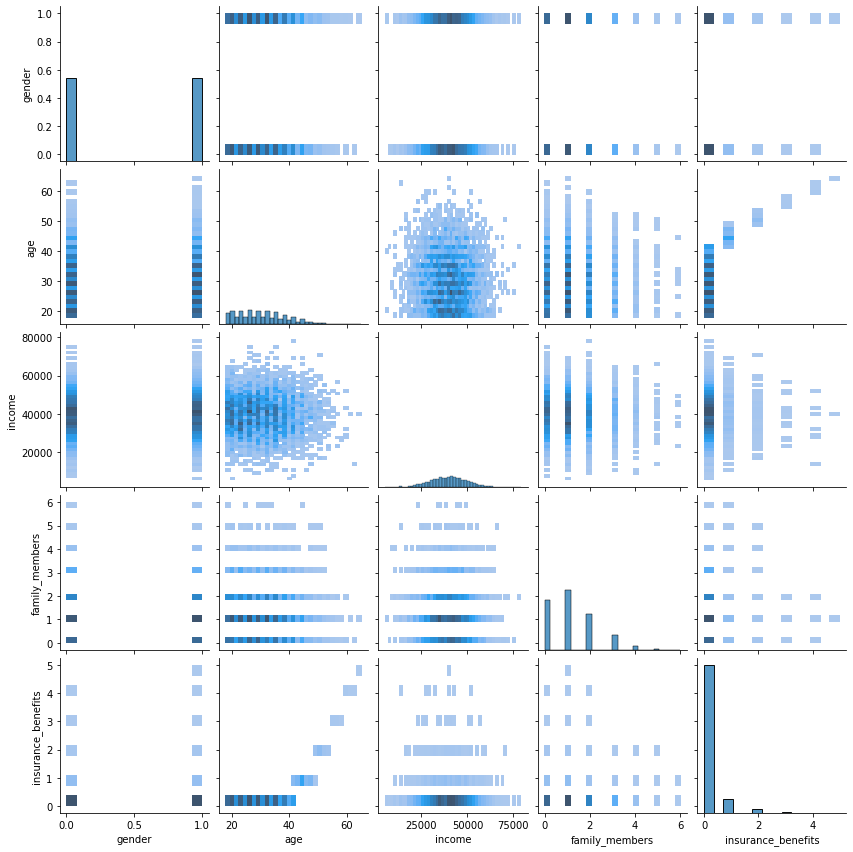

In [14]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

In [15]:
# correlation matrix
df.corr()

,gender,age,income,family_members,insurance_benefits
gender,1.000000,0.002074,0.014910,-0.008991,0.010140
age,0.002074,1.000000,-0.019093,-0.006692,0.651030
income,0.014910,-0.019093,1.000000,-0.030296,-0.014963
family_members,-0.008991,-0.006692,-0.030296,1.000000,-0.036290
insurance_benefits,0.010140,0.651030,-0.014963,-0.036290,1.000000


`age` has a moderately positive corr with `insurance_benefits`

In [16]:
features_plot= df.drop('insurance_benefits', axis=1)
target_plot= df['insurance_benefits']
features_plot = np.array(features_plot)
target_plot = np.array(target_plot)

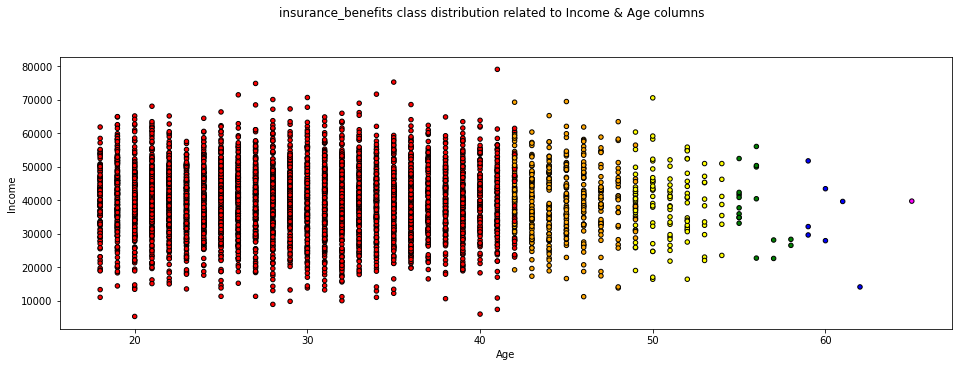

In [17]:
#Understanding insurance benefits classes distribution.
cmap = ListedColormap(['red', 'orange',  'yellow', 'green', 'blue','magenta'])
plt.figure(figsize=(16,5))
plt.scatter(features_plot[:, 1], features_plot[:, 2], c=target_plot, cmap=cmap, edgecolor='k',s=20)
plt.xlabel('Age')
plt.ylabel('Income')
plt.suptitle('insurance_benefits class distribution related to Income & Age columns', y=1.02)
plt.show();

In [18]:
#Graph proof, A single point in magenta (above) in the dataset
df.query('insurance_benefits == 5')

,gender,age,income,family_members,insurance_benefits
228,1,65,39700.0,1,5


<hr>
<b style="font-size: 20px;">Intermediate conclusions</b>

- Our insurance members info columns: `gender`,`age`,`income`,`family_benefits`,`insurance_benfits`


- We found that `age` distribution is right-skewed, When the `income` column is normal distributed


- No missing values in our data


- Our that have 153 duplicated rows (3%) , Since these rows do not interfere we do not see the need to drop them


- There is a moderately strong positive correlation between `age` of insured and `insurance_benfits`


- We can see that only one customer have the highest score in insurance_benefits  

<hr>

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [19]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [20]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, radius=0.4, metric=metric)
    nbrs.fit(df[feature_names],df['insurance_benefits'])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [21]:
#Testing Euclidean distance on unscaled data
print()
print("Euclidean distance")
display(get_knn(df, 398, 5, distance.euclidean))
print()
#Testing Manhattan distance on unscaled data
print("Manhattan distance")
display(get_knn(df, 398, 5, distance.cityblock))


Euclidean distance


,gender,age,income,family_members,insurance_benefits,distance
398,0,30,37700.0,1,0,0.000000
2599,0,32,37700.0,2,0,2.236068
152,0,26,37700.0,3,0,4.472136
2039,1,34,37700.0,3,0,4.582576
2140,1,36,37700.0,1,0,6.082763



Manhattan distance


,gender,age,income,family_members,insurance_benefits,distance
398,0,30,37700.0,1,0,0.0
2599,0,32,37700.0,2,0,3.0
152,0,26,37700.0,3,0,6.0
2039,1,34,37700.0,3,0,7.0
2140,1,36,37700.0,1,0,7.0


Scaling the data.

In [22]:
#Scaling the data
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [23]:
display(df_scaled.sample(5, random_state=0))

,gender,age,income,family_members,insurance_benefits
398,0.0,0.461538,0.477215,0.166667,0
3833,1.0,0.446154,0.553165,0.166667,0
4836,1.0,0.584615,0.551899,0.166667,0
4572,1.0,0.415385,0.549367,0.166667,0
636,0.0,0.400000,0.456962,0.166667,0


Now, let's get similar records for a given one for every combination

In [24]:
#Testing Euclidean distance on unscaled data
print()
print("Euclidean distance")
display(get_knn(df_scaled, 398, 5, distance.euclidean))
print()
#Testing Manhattan distance on unscaled data
print("Manhattan distance")
display(get_knn(df_scaled, 398, 5, distance.cityblock))


Euclidean distance


,gender,age,income,family_members,insurance_benefits,distance
398,0.0,0.461538,0.477215,0.166667,0,0.000000
4366,0.0,0.461538,0.482278,0.166667,0,0.005063
3242,0.0,0.461538,0.463291,0.166667,0,0.013924
2041,0.0,0.476923,0.478481,0.166667,0,0.015437
2238,0.0,0.476923,0.470886,0.166667,0,0.016636



Manhattan distance


,gender,age,income,family_members,insurance_benefits,distance
398,0.0,0.461538,0.477215,0.166667,0,0.000000
4366,0.0,0.461538,0.482278,0.166667,0,0.005063
3242,0.0,0.461538,0.463291,0.166667,0,0.013924
2041,0.0,0.476923,0.478481,0.166667,0,0.016650
2934,0.0,0.461538,0.458228,0.166667,0,0.018987


<hr>
<b style="font-size: 20px;">Answers our questions</b>

<b><u>Does the data being not scaled affect the kNN algorithm? If so, how does that appear?</u></b>

Our dataframe been checked as scaled and unscaled and return us a different recored within the dataset

- Unscale give our select ID '398' nearest points 2599, 152, 2140, 2039

- Scale give our select ID '398' nearest points 4366, 3242, 2041, 2934

We understand that our difference answers in our calculation case by: 

- Unscale , every column has the same weight so our calculations take in consideration the entire database

- Scale, the higher values have higher weight so the nearest points choosen taking in consideration the column weight itself

The returned results by Euclidean and Manhattan distance are different among the regarding of our data scale or not option , they even take different value in the columns. 

For example **'family_members'** column:

- Unscale all different values [2,3,1,3]

- scale the same value represented in the scaled numbers as [0.166667]

But when we check the **'income'** column we see the opposite:

- Unscale all equal values [37700.0]

- scale all different scaled values [0.482278, 0.463291, 0.478481, 0.458228]

Our opinion that this happend since the Unscale , have higher value like 377000 has major weight compared to the other column values while calculating distances

in our first example we turn out that all the values have the same income of the choosen data point were closer when other income values is heaviest then the others

in our second example we change it and insted our weights are equally distribuited for that the reason our calculations of the closest point has been done on every column

<hr><b><u>How similar are the results using the Manhattan distance metric (regardless of the scaling)?</u></b>

To our **Unscaled** data two distances returned for the same data point, while in 'Euclidean' is float values and 'Manhattan' present in integers

Our point 2599 is just rounded to the next integer (2.236068 to 3) , when other change a little bit , 152 from 4.472136 become 6 and 2039 and 2140 from 4.582576 and 6.082763 into 7

In our **Scaled** data the points are the same as well , except for the last one , when 'Euclidean' return last nearest point has number 2238 the 'Manhattan' one return id 2934

So we see that our distance equal if we consider 4366 and 3242 when since the differnt almost not notecable
<hr>

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [25]:
# calculate the target
df['insurance_benefits_received'] = (df['insurance_benefits'] >= 1).astype('int')

In [26]:
df.loc[df['insurance_benefits_received'] == True, 'insurance_benefits_received'] = 1
df.loc[df['insurance_benefits_received'] == False, 'insurance_benefits_received'] = 0

In [27]:
# check for the class imbalance with value_counts()
print(df['insurance_benefits_received'].value_counts())
print()
print(df['insurance_benefits_received'].value_counts(normalize=True))

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64


In [28]:
#Assigning features and target Unscaled data
features = df.drop(['insurance_benefits_received', 'insurance_benefits'], axis=1)
target = df['insurance_benefits_received']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.3, random_state=0)
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3500, 4) (3500,)
(1500, 4) (1500,)


In [29]:
#Scaling data
scaler = MaxAbsScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [30]:
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] >= 1).astype('int')
df_scaled.loc[df['insurance_benefits_received'] == True, 'insurance_benefits_received'] = 1
df_scaled.loc[df['insurance_benefits_received'] == False, 'insurance_benefits_received'] = 0

In [31]:
def eval_classifier(target_test, predictions):
    
    f1_score = sklearn.metrics.f1_score(target_test, predictions)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(target_test, predictions,normalize='all')
    print('Confusion Matrix')
    print(cm)

In [32]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [33]:
#Confusion matrix of dummy rnd_model predictions Unscaled data

for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    print(f'The probability: {P:.2f}')
    y_pred_rnd =  rnd_model_predict(P, features.shape[0])
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [34]:
#Confusion matrix of dummy rnd_model predictions. Scaled data
for P in [0, df_scaled['insurance_benefits_received'].sum() / len(df_scaled), 0.5, 1]:
    print(f'The probability: {P:.2f}')
    y_pred_rnd =  rnd_model_predict(P, df_scaled.shape[0])
    
    eval_classifier(df_scaled['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [35]:
#K-NeighborsClassifier for k in range 10 + f1_score. Unscaled data
print('Unscaled data')
unscaled_f1 = []
for k in range(1,11):
    knc = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knc.fit(features_train, target_train)
    knc_pred = knc.predict(features_test)
    f1_score = sklearn.metrics.f1_score(target_test, knc_pred)
    unscaled_f1.append(f1_score)
    print(f'N_neighbors: {k}, F1: {f1_score:.2f}')

Unscaled data
N_neighbors: 1, F1: 0.61
N_neighbors: 2, F1: 0.44
N_neighbors: 3, F1: 0.44
N_neighbors: 4, F1: 0.20
N_neighbors: 5, F1: 0.20
N_neighbors: 6, F1: 0.09
N_neighbors: 7, F1: 0.16
N_neighbors: 8, F1: 0.10
N_neighbors: 9, F1: 0.11
N_neighbors: 10, F1: 0.00


In [36]:
#K-NeighborsClassifier for k in range 10 + f1_score. Scaled data
print('Scaled data')
scaled_f1 = []
for k in range(1,11):
    knc = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knc.fit(features_train_scaled, target_train)
    knc_pred = knc.predict(features_test_scaled)
    f1_score = sklearn.metrics.f1_score(target_test, knc_pred)
    scaled_f1.append(f1_score)
    print(f'N_neighbors: {k}, F1: {f1_score:.2f}')

Scaled data
N_neighbors: 1, F1: 0.95
N_neighbors: 2, F1: 0.92
N_neighbors: 3, F1: 0.94
N_neighbors: 4, F1: 0.89
N_neighbors: 5, F1: 0.91
N_neighbors: 6, F1: 0.89
N_neighbors: 7, F1: 0.91
N_neighbors: 8, F1: 0.89
N_neighbors: 9, F1: 0.91
N_neighbors: 10, F1: 0.90


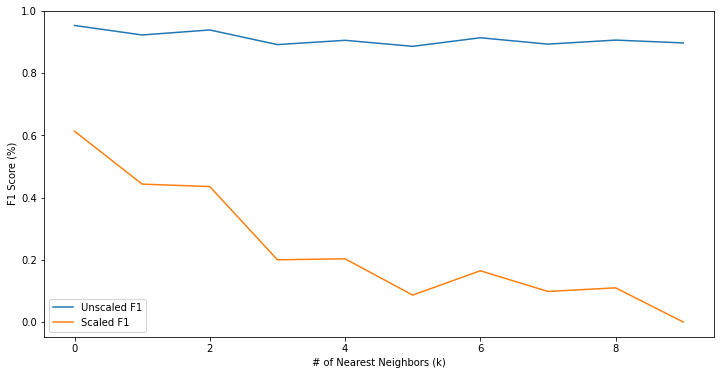

In [37]:
# Plot the results 
plt.figure(figsize=(12,6))
plt.plot(scaled_f1, label = "Unscaled F1")
plt.plot(unscaled_f1, label = 'Scaled F1')
plt.xlabel('# of Nearest Neighbors (k)')
plt.ylabel('F1 Score (%)')
plt.legend()
plt.show();

<hr>
<b style="font-size: 20px;">Intermediate conclusions</b>

- Thanks to the plot we can clearly see that there is a sharp difference between the result of the F1 score unscale and scale, when the scale score start high and get lower when the unscale is stay almost without changes and still higher than the scale F1


- So there is impact by large values features in this case `income`


- Our scale model pass the dummy model


<hr>

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [38]:
#Creating a class of LinearRegression
class MyLinearRegression:
    
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.weights = weights[1:]
        self.bias = weights[0]

    def predict(self, X):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X.dot(self.weights) + self.bias
        return y_pred

In [39]:
#def function to evaluate the classifier
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')   

In [40]:
#Testing the LR on the Unscaled data
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 3.57495491e-02  1.64272726e-02 -2.60743659e-07 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [41]:
#Testing LR on Scaled data.
X_scaled = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_scaled = df_scaled['insurance_benefits'].to_numpy()

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train_scaled, y_train_scaled)
print(lr.weights)

y_test_pred_scaled = lr.predict(X_test_scaled)
eval_regressor(y_test_scaled, y_test_pred_scaled)

[ 2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


<hr>
<b style="font-size: 20px;">Intermediate conclusions</b>

- Only 66% of the variance is explained by the features when the data is unscaled


- No difference in the RMSE or R2 score post scaling; this is expected as Linear Regression makes predictions using the units of the output, making necessary adjustments to the units of the features

<hr>

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [42]:
#Creating a database taking in consideration only the 4 features columns
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [43]:
#Generating a matrix X 
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [44]:
#Generating a matrix P 
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
print(P)

[[0.77395605 0.43887844 0.85859792 0.69736803]
 [0.09417735 0.97562235 0.7611397  0.78606431]
 [0.12811363 0.45038594 0.37079802 0.92676499]
 [0.64386512 0.82276161 0.4434142  0.22723872]]


Checking the matrix $P$ is invertible

$$ PP^{-1} = P^{-1}P = I $$

In [45]:
#Checking the invertibility of P
print(np.linalg.inv(P))

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


In [46]:
np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))

True

In [47]:
#Transforming the entire df in X1 (obfuscating data)
X1=X[:,:].dot(P)
print(X1)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


<b>Q:</b> Can you guess the customers' ages or income after the transformation?

<b>A:</b> Our data is indecipherable

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

$$ X^{'}P^{-1} = (XP)P^{-1} = X(PP^{-1})$$

In [48]:
#Dropping unecessary columns for the matrice.
df_obfuscation = df_pn[:4]
df_obfuscation = df_pn
display(df_obfuscation)

,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0
...,...,...,...,...
4995,0,28,35700.0,2
4996,0,34,52400.0,1
4997,0,20,33900.0,2
4998,1,22,32700.0,3


We are able to recover the original matrix X after matrix multiplication of the results of X*P with the inverse of P

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [49]:
#Original data
raw = np.array(df_obfuscation)
print(raw)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]


In [50]:
#Obfuscated data
obf = raw.dot(P)
print(obf)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


In [51]:
# Recovered
rec = obf.dot(np.linalg.inv(P))
print(rec)

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [ 1.67952800e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-6.23021448e-13  2.90000000e+01  2.10000000e+04 -2.03032656e-13]
 ...
 [ 1.57996161e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]


<b>Q</b> : You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

<b>A:</b> The reason for the recovered matrix not exactly matching the original matrix is due to floating point errors- there is only a finite number of bits allocated to storing real numbers
<hr>

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Analytical proof**

Given: $$
w_P = [(XP)^T XP]^{-1} (XP)^T y 
$$

By reversivity of the transpose of a product of matrices, we have
$$
w_P = [(XP)^T XP]^{-1} P^{T}X^{T} y 
$$

Rearranging the terms inside the square brackets, we have
$$
w_P = [P^{T}X^{T}XP]^{-1} P^{T}X^{T} y
$$

Expanding the term inside the square brackets, we have
$$
w_P = P^{-1}(X^{T}X)^{-1}(P^{T})^{-1}P^{T}X^{T} y
$$

Using multiplicative identity, we know $$ (P^{T})^{-1}P^{T} = P^{T}(P^{T})^{-1} = I $$
Therefore, the equation reduces to
$$
w_P = P^{-1}(X^{T}X)^{-1}IX^{T} y
$$

We can see that 
$$
w = (X^{T}X)^{-1}X^{T} y
$$

Substitute w in the above equation, we have
$$
w_P = P^{-1}w
$$

We know that
$$
y = Xw
$$

The prediction of 
$$
y_{P} = X_{P}w_{P}
$$

Subsitute $$ w_{P} $$

In the above euqation, we get
$$
y_{P} = X_{P}(P^{-1}w)
$$

From obsfuscating the input X, we have
$$
X_{P} = XP
$$

Subsititute this in the above equation, we have
$$
y_{P} = XPP^{-1}w
$$

From multiplicative identity, we know $$ (P^{T})^{-1}P^{T} = P^{T}(P^{T})^{-1} = I $$

Therefore, we are left with
$$
y = y_{P} = Xw
$$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Draw $P$ from a uniform distribution
- Use $XP$ as the new feature matrix

In [52]:
def generate_square_matrix(num_features, seed=42):
    """
    Generate a square matrix from a uniform distribution
    """
    rng = np.random.default_rng(seed=seed)
    return rng.random(size=(num_features, num_features))

In [53]:
P = generate_square_matrix(4, seed=1234)

In [54]:
def is_invertible(P):
    """
    Check if P is invertible or not
    """
    return np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))

In [55]:
is_invertible(P)

True

In [56]:
class MyLinearRegression_obf:
    
    def __init__(self, data):
        self.weights = None
        self.data = data
        
    def fit(self, X, y):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        self.weights = weights[1:]
        self.bias = weights[0]

    def predict(self, X):
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X.dot(self.weights) + self.bias
        return y_pred

In [57]:
#MyLinearRegression_obf on the normal dataset.
X = X
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression_obf(X)

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 1.64272726e-02  3.57495491e-02 -2.60743659e-07 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [58]:
#MyLinearRegression_obf on the obfuscated dataset.
X = X1
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression_obf(X1)

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.05791721 -0.01546571  0.09871894 -0.02397536]
RMSE: 0.34
R2: 0.66


# Conclusions

Thanks to our NearestNeighbors imported library to obtain the K neighbors given us a data points , That we can do scale of our data change to total results , When our data not scale at all. The result we got are similar on the big values (for ex' 'income' column) , Since the bigger values also have the highest weughts on our results. When scale the data we can return the right neighbors taking to consideration all the features.

We indentified the targets of this taks being 1 for any person that received at least one insurance benefit and 0 for customers that doesn't have one. the distribution of those values in our dataset is 88.72% (0) and 11.28% (1). 

Our dummy model values in general very very low, using the KNeiborghsClassifier , we plot a chart that show the F1 Score vs any K values , our Unscaled data show higher value in 60% with K==1 , Our predictions result show value of 100% this mean that the precision and the recall of the model itself are in the best possible percentage.  

We built our own LinearRegression model evaluating it into two different metrics , first RMSE (Root mean squared error) and R2 score , perfoming predictions on scale and unscale data , Doesn't make any difference and the **RMSE** was calc in **0.34** that is the modest result , it's mean that on a scale from 0 t0 1 the mistake made from the model prediction are 34% , **R2** score in a range of 100, returned **66%**.

In our task required to obfusc the data in our hands, To make that we created a matrice P which was invertible and multiplied it for our features matrice X. the dot product returend another matrice X1 , that hides data letting them been not recognizable. To revert the process to reobtain the starting values. We prove that our LR model is performs the predictions in the same way on the obfuscated data having the same quality and the same metrics values. 

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells are arranged in order of logic and execution
- [x]  Task 1 has been performed
    - [x]  There is the procedure that can return k similar customers for a given one
    - [x]  The procedure is tested for all four proposed combinations
    - [x]  The questions re the scaling/distances are answered
- [x]  Task 2 has been performed
    - [x]  The random classification model is built and tested for all for probability levels
    - [x]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [x]  Task 3 has been performed
    - [x]  The linear tegression solution is implemented with matrix operations.
    - [x]  RMSE is calculated for the implemented solution.
- [x]  Task 4 has been performed
    - [x]  The data is obfuscated with a random and invertible matrix P
    - [x]  The obfuscated data is recoved, few examples are printed out
    - [x]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x]  The computational proof that the transformation does not affect RMSE is provided
- [x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>